# Evaluation of Model on Final unseen races of 2022 & Project Summary

Author : Ben Palmer\
Date : 02/11/2022

## Summary:
This notebook has analysed the predictive power of the trained models on the last 4 races of 2022, which is a completely unseen dataset as the qualifying and races occured during the project after the original data was downloaded.

The results show that:
- The models predicted the overall trends well, were able to predict the top drivers from the bottom drivers in both position and lap time delta
- The position model predicts a float and not ranked results, therefore to compare the predictions need to be ranked 1 to 20. For example it can predict 3.3 and 3.7 for two drivers but these positions don't exist in reality. 
- Predicted Max Verstappen to get pole correctly twice.
- Predicted Hamilton's position quite closely

- The models had lower R2 and Mean Aboslute Error Scores than the original Test set, which is expected of a reality test set
- The model struggled to predict lap time delta especially in Singapore, often over predicting the top drivers and under predicting the bottom drivers
- Over the course of the season the models did well especially for the races they had been trained on, and less well on races they had not. Indicating there may be slight over training in the models.

Overall this project has learned a number of interesting features, including:
- The variance & maximum RPM (revolution per minute) of the engine on the straight
- The maximum speed on the corners
- The amount of distance a driver spent on the brakes in a given lap
- Initial Sector 1 times 
- Speed on the straights

The models have a number of limitations as well:
- Both the laptime delta and position prediction models show signs of over training with the test sets doing worse than the training datasets
- The dataset was small for machine learning with 1890 rows and high number of features the models will suffer with dimensionality and the lack of data
- The lap time delta model performed poorly on the "test" test set with mean absolute errors of 0.8 seconds
- As a regression technique was used the models especially for position did not predict the range of outcomes (1-20) and the data needed to be ranked afterwards to match
- Some of the features have outliers which can highly impact the predicted results. 
- The model struggled with unseen circuits, especially on lap time delta. This is likely because the features show more variability between circuits than driver performance

Recommendations for further work, include: 

- Normalising the input features to the circuit characteristics.
- Generating features that look at the past Grand Prix's performance as an indicator of future results.
- Using automatic feature engineering techniques such as auto encoders.
- Investigating classification models with bin size of 1 for position predictions.
- Build models to predict off practice 3 performance features. 
- Predict results at a lap level not at a race level. 

## Introduction:

The aim of this notebook is to evaluate the performance of the optimised models on the last 4 races of the 2022 season. This races occured whilst the project was being conducted and therefore were not included in the original dataset for analysis and modelling. These races are close to a production test set, a "test" test set. The performance of the models on this data will give us an indication of how the models are likely to perform in reality. 

In addition this notebook would summarise the performance of the models over the 2022 season up to present day to provide a summary of performance and predictive power of the models as a whole.

## Table of Contents:
1. [Predicting New Data Results](#newdata)\
    1.1[Prepare data for Modelling](#prep)\
    1.2[Predict & Evaluate Qualifying Results](#pos)\
    1.3[Predict & Evaluate Qualifying Lap time](#delta)
   

2. [Predictions vs True for 2022](#2022)\
    1.1 [Predict early 2022](#predict)\
    1.2 [combine predictions](#combine)\
    1.3 [2022 Results](#summary)

3. [Project Summary](#projsummary)

4. [Recommendations for Further Work](#recommendations)
    

### Imports

In [17]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import seaborn as sns
from scipy import stats

from scripts.ds_ultils import *
from scripts.fastf1_data_download import *
from scripts.model_ultils import *

plt.style.use('./scripts/plotstyle.mplstyle')

import joblib
from mlxtend.feature_selection import ColumnSelector
from scipy.stats import rankdata
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectFromModel, SelectKBest
from sklearn.linear_model import LinearRegression
from sklearn.metrics import (accuracy_score, classification_report,
                             confusion_matrix, mean_absolute_error,
                             mean_squared_error, plot_roc_curve, r2_score,
                             roc_auc_score)
from sklearn.model_selection import (GridSearchCV, RandomizedSearchCV,
                                     cross_val_score, train_test_split)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (LabelEncoder, MinMaxScaler, OneHotEncoder,
                                   StandardScaler)
from xgboost import XGBRegressor


The last 4 races Singapore, Suzuka, Austin and Mexico City, in addittion these races where not included in the original Ergast Database download. Therefore no results data has been collected. The data will be collected from the fastf1 api link to F1 live. However the data will be needed to be processed to match the same format as the previous data especially regarding format of the categorical variables. This is done for the results and categorical data before pulling all the telemetry data and creating the features as done for the previous dataset.

This code block has been run and the data saved to the model_data folder as:

`formula1_2022_last_races_model_data.pkl`

In [ ]:
#download the data from the api, this takes a few hours and has been completed and results saved for you.
#file='./data/clean/combined_ergast_clean.csv'
#event_df=get_year_quali()
#event_df=new_sessions(file,event_df)
#new_results_df=get_new_results_dataframe(file,event_df)
#new_data = pull_new_races_aggregate_telemetry(new_results_df)
#new_data.to_pickle('./data/model_data/formula1_2022_last_races_model_data.pkl',compression='gzip')

# Predicting New Data Results for 2022
<a id="newdata"></a>

First read in the new data, which the above code block saved as a temporary file.

In [3]:
new_data_df=pd.read_pickle('./data/model_data/formula1_2022_last_races_model_data.pkl',compression='gzip')

## Preparing data for modelling
<a id="prep"></a>

Similar to the larger dataset, the data needs to be prepared before any predictions can be made. This is to ensure it is in the same format as the dataset that the models were trained on. The prepare modelling function:
- converts columns which are numeric to float
- Creates the target features and bins
- Creates the home country feature
- Cleans the dataframe 
- Fixes the GrandPrix where the DRS telemetry data was not working. 

However because we are only predicting and not training, test split is False to return just a X and y dataframe

The y features are split into position features and lap time delta.

The next step is to select the manual features which were considered important from the analysis in notebook [6_Formula1_Initial_Modelling](./6_Formula1_Initial_Modelling.ipynb). Similar to previous analysis the Sector Times of Fastest Lap are removed since these are just the break down of the times of the target and therefore not considered an input feature


In [6]:

X_new_races, y_new_races = prepare_modelling_df(new_data_df,test_split=False)
ypos_new_races =y_new_races['quali_position'].copy()
ydelta_new_races=abs(y_new_races['lap_timedelta_milliseconds'].copy())

feature_importance=pd.read_pickle('./data/model_data/feature_importance_random_forest.pkl')
manual_features = list(feature_importance[feature_importance['Random_forest_result']>0.0105].index)
features_remove =[ 'numerical_transform__fastestlap_Sector1',
 'numerical_transform__fastestlap_Sector2',
 'numerical_transform__fastestlap_Sector3', 
 ] 
manual_features = [x for x in manual_features if x not in features_remove]
X_new_races_manual = apply_manual_features_X(X_new_races,features=manual_features)


## Predict Position
<a id="pos"></a>

This section will predict the Qualifying position for the last 4 races of the 2022 season

In [7]:
#load model
Position_RF_model=joblib.load('./pickled_best_RF_regression_model_position.pkl')

Summary of the model, it consisents of a column transformer to scale the numerical columns and encode the categorical columns. Then a Random Forest Regressor to predict Qualifying position

In [8]:
Position_RF_model

Pipeline(steps=[('column_transform',
                 ColumnTransformer(transformers=[('numerical_transform',
                                                  StandardScaler(),
                                                  ['circuit_total_corner_curvature',
                                                   'circuit_mean_corner_curvature',
                                                   'max_max_speed',
                                                   'mean_straight_speed',
                                                   'var_straight_speed',
                                                   'max_fastest_accleration',
                                                   'mean_max_lap_accleration',
                                                   'max_fastest_lap_rpm',
                                                   'var_fastest_lap_straight_rpm',
                                                   'mean_faste...
                                                   'avg_lap_bottom_speed_corner',
                                                   'avg_lap_max_speed_corner',
                                                   'fl_lap_distance_on_brake',
                                                   'avglap_Sector1',
                                                   'fastestlap_track_temperature',
                                                   'avg_lap_track_temperature',
                                                   'avg_lap_humidty', 'age']),
                                                 ('hot_encode',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['driverRef',
                                                   'constructorRef'])])),
                ('random_forest',
                 RandomForestRegressor(max_depth=45, max_features=20,
                                       n_estimators=90))])

The qualifying results can predicted with simiply calling predict on the X features

In [9]:
position_new_predictions= Position_RF_model.predict(X_new_races_manual)

In [10]:
position_new_predictions

array([ 3.23333333,  5.02222222,  6.28888889,  6.83333333, 11.48888889,
        5.87777778,  9.47777778,  6.91111111, 13.56666667,  8.62222222,
       10.08888889, 12.25555556, 12.65555556, 14.66666667, 16.65555556,
       15.68888889, 10.73333333, 14.55555556, 12.83333333, 17.07777778,
        3.72222222,  6.57777778,  5.87777778,  5.22222222, 11.65555556,
        4.22222222,  9.37777778, 12.15555556, 12.07777778, 12.34444444,
       13.48888889, 11.27777778, 10.47777778, 14.71111111, 15.12222222,
       14.03333333, 14.57777778, 15.88888889, 17.71111111,  5.88888889,
        7.1       ,  4.95555556,  4.55555556, 10.78888889,  9.42222222,
       11.16666667,  3.88888889, 11.92222222, 12.08888889,  6.61111111,
       15.27777778, 14.44444444, 12.87777778, 13.57777778, 12.21111111,
       11.05555556, 12.75555556, 14.4       , 15.12222222,  4.08888889,
        2.95555556,  2.58888889,  5.27777778,  5.05555556,  5.75555556,
       14.72222222,  8.92222222, 11.43333333, 13.12222222, 17.23

The predictions are for the last 4 races per driver, they are also floats where as the true results are integers. This is because the models is a regression model and can predict any number. One alternative method to avoid this would be a classification model with a bin size of 1. To correct for this the results can be also be ranked in order of prediction to give a result more indicative of position.

First what are the model evaluation scores for the last 4 races of 2022

In [11]:
print(f'Lap Delta Random Forest regression Initial R2 score with manual selected featuers {r2_score(ypos_new_races,position_new_predictions)}')
print(f'Lap Delta Random Forest regression Initial MSE score with manual selected feaure {mean_squared_error(ypos_new_races,position_new_predictions)}')
print(f'Lap Delta Random Forest regression Initial MAE score with manual selected feaure {mean_absolute_error(ypos_new_races,position_new_predictions)}')

Lap Delta Random Forest regression Initial R2 score with manual selected featuers 0.6465598182660639
Lap Delta Random Forest regression Initial MSE score with manual selected feaure 11.709228004375683
Lap Delta Random Forest regression Initial MAE score with manual selected feaure 2.8355836849507736


The R2 is similar to the previous test set with a Mean Aboslute error of 2.8 slightly higher to what was predicted previously. This can be compared by  looking at the predictions versus true values on a scatter plot

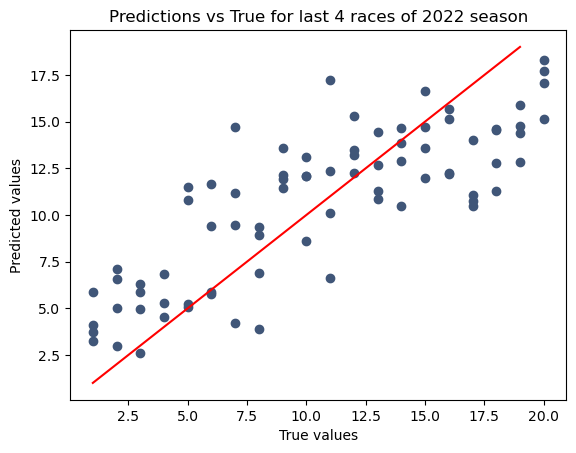

In [12]:
plt.scatter(ypos_new_races,position_new_predictions)
plt.plot(np.arange(1,20,1),np.arange(1,20,1),c='r')
plt.xlabel('True values')
plt.ylabel('Predicted values')
plt.title('Predictions vs True for last 4 races of 2022 season')
plt.show()

The red line shows the perfect predictions where True=Predictions. The model seems to over predict results for the top drivers and under predict (predict better results) for the bottom drivers. This may be due to features in these GrandPrix's which the model thinks all the drivers are more equal. Maybe as the season has progressed the difference beteween drivers and cars has reduced such that the model thinks the drivers are more similar.

How about if we rank the results for 1 Grandprix and compared the model ranked results with the actual results.

In [43]:
print('Singapore GrandPrix 2022 Results')
pos_comparison = new_data_df[['quali_position','driverRef','circuitRef']]
pos_comparison['position_predicted'] = position_new_predictions
singapore_position = pos_comparison[pos_comparison['circuitRef'] =='marina_bay'].copy()
singapore_position

Singapore GrandPrix 2022 Results


,quali_position,driverRef,circuitRef,position_predicted
0,1.0,leclerc,marina_bay,5.888889
1,2.0,perez,marina_bay,7.100000
2,3.0,hamilton,marina_bay,4.955556
3,4.0,sainz,marina_bay,4.555556
4,5.0,alonso,marina_bay,10.788889
5,6.0,norris,marina_bay,9.422222
6,7.0,gasly,marina_bay,11.166667
7,8.0,max_verstappen,marina_bay,3.888889
8,9.0,kevin_magnussen,marina_bay,11.922222
9,10.0,tsunoda,marina_bay,12.088889


In [44]:
# Use scipy function to rank the predictions for singapore
singapore_position['position_predicted_ranked'] = rankdata(singapore_position['position_predicted'])

Plot the predictions ranked such that the predictions are 1-20 in order of how the model assigned the position scores. 

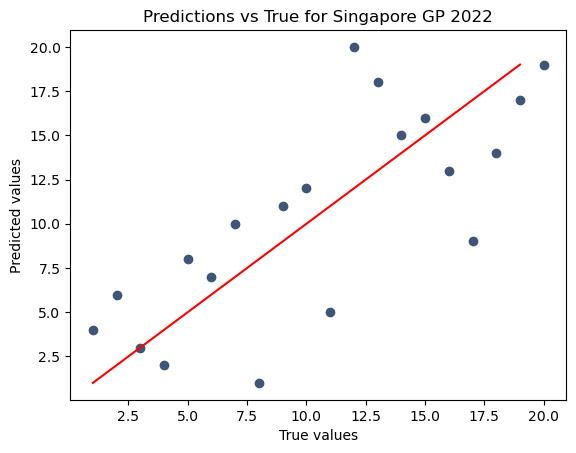

In [45]:
plt.scatter(singapore_position['quali_position'],singapore_position['position_predicted_ranked'])
plt.plot(np.arange(1,20,1),np.arange(1,20,1),c='r')
plt.xlabel('True values')
plt.ylabel('Predicted values')
plt.title('Predictions vs True for Singapore GP 2022')
plt.show()

As can be observed the model captures the trend but gets a few drivers badly wrong. It generally predicts the top 10 drivers to do worse than they did, but mostly in the right order. Max Verstappen who has dominated 2022 is predicted to get pole, therefore it maybe affected by the categorical dummy variable for max more than his driving data. It under predicts for Russell and Bottas as well probably because of either the team they driver for or there previous results. It over predicts for Mick Schumacher and Stroll probably related to their previous results.  

On a positive note apart from clear errors it gets the order for the top 15 more or less right, with the exception of Max Verstappen it gets the top 3 right just in the wrong order. Plus the drivers from 5th to 10th are also in the right order just offsetted.

In [47]:
print(f"Lap Delta Random Forest regression Initial R2 score with manual selected featuers {r2_score(singapore_position['quali_position'],singapore_position['position_predicted_ranked'])}")
print(f"Lap Delta Random Forest regression Initial MSE score with manual selected feaure {mean_squared_error(singapore_position['quali_position'],singapore_position['position_predicted_ranked'])}")
print(f"Lap Delta Random Forest regression Initial MAE score with manual selected feaure {mean_absolute_error(singapore_position['quali_position'],singapore_position['position_predicted_ranked'])}")

Lap Delta Random Forest regression Initial R2 score with manual selected featuers 0.5097744360902255
Lap Delta Random Forest regression Initial MSE score with manual selected feaure 16.3
Lap Delta Random Forest regression Initial MAE score with manual selected feaure 3.3


As we can see ranking the data an impact on the metrics this is because the errors are maginfied. In the unranked predictions the top drivers were predicted worse and the worse drivers predicted better, averaging out the drivers performance which can reduce the error as the model becomes less extreme or sure it its predictions. It predicts some drivers to do well but not too sure and some to do poor but also not too sure. Therefore this reduces the Mean absoute error. By ranking the Mean Absolute Error increases as the the unsure points are forced to fill the full range. 


# Lap time delta predictions
<a id="delta"></a>

This section will predict the lap time delta for the last 4 races of 2022.

First load the XGboost model for predicting lap time deltas

In [26]:
Lapdelta_XG_model=joblib.load('./pickled_best_XGboost_regression_model_lap_delta.pkl')

Predict the lap time deltas for the last 4 races:

In [49]:
lapdelta_new_predictions= Lapdelta_XG_model.predict(X_new_races_manual)

In [50]:
lapdelta_new_predictions

array([ 828.8906 , 1224.6226 , 1108.7023 , 1136.83   , 1490.9868 ,
       1137.063  , 1406.6616 ,  881.9744 , 2360.684  , 1417.9069 ,
       1768.709  , 2570.566  , 1761.5958 , 2401.3777 , 2130.8342 ,
       2572.6228 , 1672.9349 , 2061.6738 , 1931.9922 , 2697.1165 ,
        778.7882 ,  975.53064,  976.50134,  634.99347, 2174.1423 ,
        632.90466, 1616.9286 , 1814.7242 , 1846.1937 , 1672.9674 ,
       2003.7747 , 1835.8964 , 1744.5713 , 2175.9766 , 2158.7976 ,
       1697.7538 , 1829.0006 , 3286.9717 , 2932.3528 , 2804.3289 ,
       3161.5325 , 2931.1016 , 2183.617  , 3205.6296 , 3530.8914 ,
       3513.9485 , 2586.934  , 3392.7412 , 3773.1638 , 2387.0234 ,
       4071.9377 , 4263.463  , 4702.6255 , 3978.7087 , 4474.8335 ,
       5686.116  , 4754.2104 , 4530.589  , 3682.605  ,  211.24908,
        288.49893, 1063.2504 ,  708.4748 , 1007.7418 , 1073.4808 ,
       2343.22   ,  860.8342 , 1868.8442 , 2803.1848 , 3335.964  ,
       1868.3608 , 1544.3683 , 2188.085  , 1463.0657 , 2503.37

The output is an array of lap time deltas for the last 4 races of 2022. How did the model perform against the true values?

In [51]:
print(f'Lap Delta Random Forest regression Initial R2 score with manual selected featuers {r2_score(ydelta_new_races,lapdelta_new_predictions)}')
print(f'Lap Delta Random Forest regression Initial MSE score with manual selected feaure {mean_squared_error(ydelta_new_races,lapdelta_new_predictions)}')
print(f'Lap Delta Random Forest regression Initial MAE score with manual selected feaure {mean_absolute_error(ydelta_new_races,lapdelta_new_predictions)}')

Lap Delta Random Forest regression Initial R2 score with manual selected featuers 0.5426193653332451
Lap Delta Random Forest regression Initial MSE score with manual selected feaure 1561133.7669131658
Lap Delta Random Forest regression Initial MAE score with manual selected feaure 893.7902217816703


In this "test" test set, the lap time delta did worse than the with the previous test set, with a worse R2 and MAE error. The Model had a mean error of 900 milliseconds or 0.9s (9/10ths of the second). Lets see how the results were distributed. Was the model worse at predicting certain results?

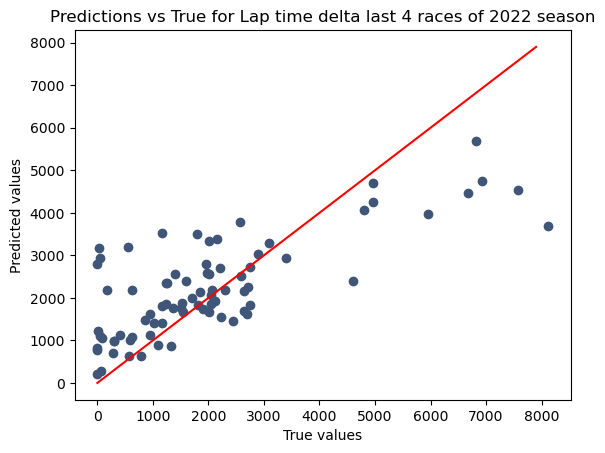

In [52]:
plt.scatter(ydelta_new_races,lapdelta_new_predictions)
plt.plot(np.arange(1,8000,100),np.arange(1,8000,100),c='r')
plt.xlabel('True values')
plt.ylabel('Predicted values')
plt.title('Predictions vs True for Lap time delta last 4 races of 2022 season')
plt.show()

WHen looking at the predictions vs true values the majority of points are captured between 0 to 4 seconds (4000 milliseconds) away from the pole sitter. The majoirt of these points are close to the true prediction line (red), similar to the position the model averages out the score over predicting the top drivers delta and under prediction the worse drivers results, especially in the small tail from 4 to 8s. These are anomalous data points and it can be expected that the model may struggle with these data points.

There is another interesting data cloud, sitting above the true prediction line predicted at 3 s behind the pole sitter, there are a cluster of predicted points where the model predicted 3s delta for both the front drivers to the drivers who were actually 3 seconds back. This is probably one single GrandPrix where the model struggled. As shown in the evaluation of the model in [8_Formula1_Regression_models]('./8_Formula1_Regression_models.ipynb') the lap time delta model is affected most by features like avglap sector 1 times and RPM on the straight, if the GrandPrix has a partically long sector 1 time or the engines can run at the high RPM because the straights are short the model will predict high lap time deltas which are in fact wrong.

This confirms the challenges of predicting lap time delta due to the fact there are so many variables that complicate the actual time result and the difference between results. As discussed addittional features which are nominalised for different circuit lengths may help the predictive power of lap time delta. If avg sector time was also a lap time delta between the drivers that may help the model. If the metrics of speed and rpm on the straights was nominalised for straight length as well may help the model.

Lets investigate further by looking at the results of a couple of GrandPrix's

In [55]:
print('Singapore GrandPrix 2022 Results')
delta_comparison = new_data_df[['lap_timedelta_milliseconds','driverRef','circuitRef']]
delta_comparison['lap_timedelta_milliseconds'] = abs(delta_comparison['lap_timedelta_milliseconds'])
delta_comparison['laptime_delta_predicted'] = lapdelta_new_predictions
delta_comparison['Residuals'] = delta_comparison['laptime_delta_predicted'] - delta_comparison['lap_timedelta_milliseconds']
singapore_position = delta_comparison[delta_comparison['circuitRef'] =='marina_bay'].copy()
singapore_position

Singapore GrandPrix 2022 Results


,lap_timedelta_milliseconds,driverRef,circuitRef,laptime_delta_predicted,Residuals
0,0.0,leclerc,marina_bay,2804.328857,2804.328857
1,22.0,perez,marina_bay,3161.532471,3139.532471
2,54.0,hamilton,marina_bay,2931.101562,2877.101562
3,171.0,sainz,marina_bay,2183.616943,2012.616943
4,554.0,alonso,marina_bay,3205.629639,2651.629639
5,1172.0,norris,marina_bay,3530.891357,2358.891357
6,1799.0,gasly,marina_bay,3513.948486,1714.948486
7,1983.0,max_verstappen,marina_bay,2586.934082,603.934082
8,2161.0,kevin_magnussen,marina_bay,3392.741211,1231.741211
9,2571.0,tsunoda,marina_bay,3773.163818,1202.163818


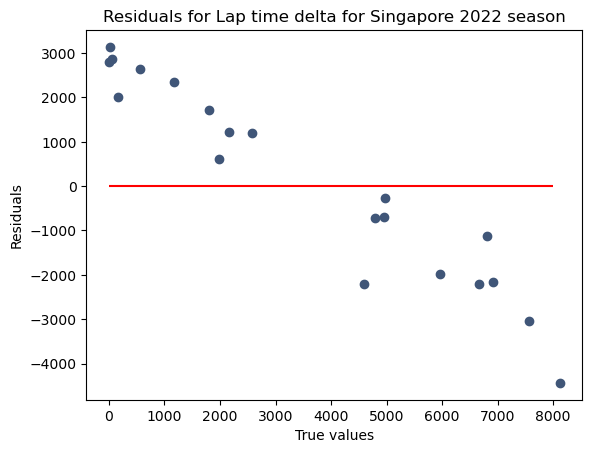

In [57]:
plt.scatter(singapore_position['lap_timedelta_milliseconds'],singapore_position['Residuals'])
plt.hlines(0,0,8000,color='r')
plt.xlabel('True values')
plt.ylabel('Residuals')
plt.title('Residuals for Lap time delta for Singapore 2022 season')
plt.show()

As cna be seen from the Singapore residuals this is the GrandPrix that corresponded to the cloud of points high above the true prediction red line in the overal plot, and also the grandprix that had the results with a large tail of points going out to 8seconds back. This GrandPrix the model clearly struggled with to get the lap time delta right. This GrandPrix is a street circuit, with lots of short straights and tight corners. Hence the cars can not get up to full speed and are trying to thread the needle between the tight walled off streets of Singapore. Therefore larger variation of lap times is expected. In adittion the cars do not reach their top speeds they would expect on a larger more open circuit. Therefore the features of RPM, Speed and sector times would be very different to other GrandPrix's hence this is likely why the model performed so poorly for this Grand Prix

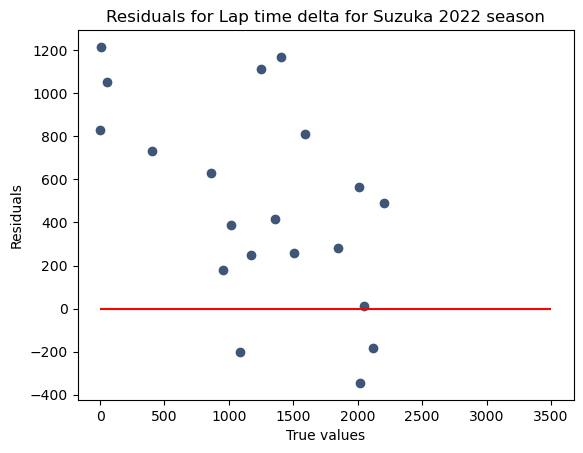

In [58]:
suzaka_position = delta_comparison[delta_comparison['circuitRef'] =='suzuka'].copy()

plt.scatter(suzaka_position['lap_timedelta_milliseconds'],suzaka_position['Residuals'])
plt.hlines(0,0,3500,color='r')
plt.xlabel('True values')
plt.ylabel('Residuals')
plt.title('Residuals for Lap time delta for Suzuka 2022 season')
plt.show()

For Suzaka the model performed better with all the drivers within 1.2 seconds of there true values. However similar to Singapore the model over predicted the times of most drivers. Suzuka is a long but fast circuit and it may have been more affected by features like avg lap sector time

# Predictions versus Reality for 2022
<a id="2022"></a>

How good are the model predictions for the 2022 season as a whole?

To answer this question would require combining the predictions from the previous dataset with the predictions of the last 4 races in this notebook.

To do this we will extract the 2022 races from the previous dataset and re run the predictions for just the 2022 races. This would include races the model was trained on and ones it was not trained on.

First read the previous dataset:

In [59]:
qualify_df=pd.read_pickle('./data/model_data/formula1_complete_2018_2022_complete_301022.pkl',compression='gzip')
qualifying_df=qualify_df.copy()


Select only the 2022 races:

In [60]:
initial_2022_races_df = qualifying_df[qualifying_df['year'] == 2022].copy()

## Predict position and Lap time delta 
<a id="predict"></a>

For the early 2022 races predict the position and laptime delta

This requires preparing the data for modelling and applying the manaul feature selection

In [61]:
X_22_races, y_22_races = prepare_modelling_df(initial_2022_races_df,test_split=False)
ypos_22_races =y_22_races['quali_position'].copy()
ydelta_22_races=abs(y_22_races['lap_timedelta_milliseconds'].copy())

X_22_races_manual = apply_manual_features_X(X_22_races,features=manual_features)


Run the predictions for position and Lap time delta:

In [27]:
position_22_predictions= Position_RF_model.predict(X_22_races_manual)
lapdelta_22_predictions= Lapdelta_XG_model.predict(X_22_races_manual)

## Combine into a Summary Table
<a id="combine"></a>

How did the model perform over the whole 2022 season? To evaluate its performance we need to combine the results from 2022 races in the original dataset and last 4 races.

Create a summary table from the early 2022 predictions:

In [38]:
summary_22_df = initial_2022_races_df[['driverRef','circuitRef','quali_position','lap_timedelta_milliseconds']].copy()
summary_22_df['predicted_position_model'] = position_22_predictions
summary_22_df['predicted_laptime_delta'] = lapdelta_22_predictions
summary_22_df['lap_timedelta_milliseconds']= abs(summary_22_df['lap_timedelta_milliseconds'])

For the position predictions, they need to be ranked to force the results to go from positions 1 to 20

In [62]:
circuits = summary_22_df['circuitRef'].unique()
for circuit in circuits:
    query = summary_22_df['circuitRef'] == circuit
    summary_22_df.loc[query,'predicted_position_ranked'] = rankdata(summary_22_df.loc[query,'predicted_position_model'])
    


The summary dataframe will contain information of:
- driver
- circuit
- True qualifying position
- Lap time detla prediction
- Predicted position & ranked position
- Predicted lap time delta

In [63]:
summary_22_df.head()

,driverRef,circuitRef,quali_position,lap_timedelta_milliseconds,predicted_position_model,predicted_laptime_delta,predicted_position_ranked
40,leclerc,albert_park,1.0,0.0,4.522222,683.990234,2.0
42,perez,albert_park,3.0,372.0,4.255556,499.128174,1.0
43,norris,albert_park,4.0,835.0,5.944444,923.581238,5.0
44,hamilton,albert_park,5.0,957.0,4.900000,862.161499,3.0
45,russell,albert_park,6.0,1065.0,5.922222,702.802734,4.0


This dataframe is created for the results of the last 4 races

In [64]:
newraces_22_df = new_data_df[['driverRef','circuitRef','quali_position','lap_timedelta_milliseconds']].copy()
newraces_22_df['predicted_position_model'] = position_new_predictions
newraces_22_df['predicted_laptime_delta'] = lapdelta_new_predictions
newraces_22_df['lap_timedelta_milliseconds']= abs(newraces_22_df['lap_timedelta_milliseconds'])

The predicted positions are ranked 0 to 20:

In [65]:
circuits = newraces_22_df['circuitRef'].unique()
for circuit in circuits:
    query = newraces_22_df['circuitRef'] == circuit
    newraces_22_df.loc[query,'predicted_position_ranked'] = rankdata(newraces_22_df.loc[query,'predicted_position_model'])
    

Now to combine the two dataframes of 2022 season together

In [66]:
summary_22_combined = pd.concat([summary_22_df,newraces_22_df])
summary_22_combined.reset_index(drop=True)
summary_22_combined['laptime_delta_residual'] = summary_22_combined['lap_timedelta_milliseconds'] - summary_22_combined['predicted_laptime_delta']
summary_22_combined.head()

,driverRef,circuitRef,quali_position,lap_timedelta_milliseconds,predicted_position_model,predicted_laptime_delta,predicted_position_ranked,laptime_delta_residual
40,leclerc,albert_park,1.0,0.0,4.522222,683.990234,2.0,-683.990234
42,perez,albert_park,3.0,372.0,4.255556,499.128174,1.0,-127.128174
43,norris,albert_park,4.0,835.0,5.944444,923.581238,5.0,-88.581238
44,hamilton,albert_park,5.0,957.0,4.900000,862.161499,3.0,94.838501
45,russell,albert_park,6.0,1065.0,5.922222,702.802734,4.0,362.197266


# Summary of Results 
<a id="summary"></a>

With the summary dataframe of results and predictions, we can ask questions like;
 - How good was the model at predicting Pole Position?
 - How well did it do for certain drivers throughout the year?

Lets create a dataframe of pole winners by selecting the driver who was on True Pole and selecting the driver the model predicted to be pole for each circuit.

In [87]:
pole_winner=pd.DataFrame()
pole_winner['circuitRef'] = summary_22_combined['circuitRef'].unique()
pole_winner['True_pole_sitter']=''
pole_winner['predicted_pole_sitter']=''
circuits = summary_22_combined['circuitRef'].unique()
for circuit in circuits:

    circuit_query = pole_winner['circuitRef'] == circuit
    circuit_query2 = summary_22_combined['circuitRef'] == circuit    
    query1 = summary_22_combined['quali_position'] == 1.0
    if len(summary_22_combined.loc[(query1) & (circuit_query2),'driverRef'].values) > 0: # some races do not have rows for the pole position driver because no telemetry data was recored for that driver in qualifying. Therefore we need to check for than and assign a NaN value for that entry
        true_position =summary_22_combined.loc[(query1) & (circuit_query2),'driverRef'].values[0]
    else:
        true_position = np.NaN 

    pole_winner.loc[circuit_query,'True_pole_sitter'] = true_position
    
    query2 = summary_22_combined['predicted_position_ranked'] == 1.0
    pole_winner.loc[circuit_query,'predicted_pole_sitter'] = summary_22_combined.loc[(query2) & (circuit_query2),'driverRef'].values[0]
   

In [88]:
pole_winner

,circuitRef,True_pole_sitter,predicted_pole_sitter
0,albert_park,leclerc,perez
1,red_bull_ring,NaN,leclerc
2,baku,leclerc,leclerc
3,bahrain,leclerc,leclerc
4,spa,NaN,sainz
5,silverstone,sainz,sainz
6,villeneuve,NaN,hamilton
7,zandvoort,NaN,hamilton
8,imola,NaN,leclerc
9,ricard,leclerc,leclerc


Here we have a table where we can compare how the model did predicting pole position against the true pole sitter. A couple of observations jump out immediately:
- Where do the NaN values come from in True pole sitter?
- Overall the model does well only in correctly predicting the pole sitter where there is data 3 times

Firstly the NaN values come from Max Verstappen, as mentioned when the data was downloaded from the API ([6_Formula1_Initial_Modelling]('./6_Formula1_Initial_Modelling.ipynb')) there are occurences where no telemetry data is collected for a driver for a particular race. Max has the most drop outs of telemetry data for every driver and in 2022 all those drop outs occur when we gets pole position...
Therefore all the NaN values are for MaxVerstappen. 

At face value the model seems to do well overall, however the model was trained on most of the races, only 6 races are Test races. These are:
- Red Bull Ring
- Zandvoort 
from the original dataset and the last 4 races:
- Suzuka
- Rodriguez
- Marina Bay
- Americas 

The two test races in the original dataset Max got pole and there was no data for the model to predict Max. The last 4 races the model predicted Max all the time, it got it right 2 out of 4 times. 

Therefore the model maybe showing signs of over training. 

How does it vary for certain drivers over the year?

Select the results for certain drivers:

In [112]:
hamilton_results = summary_22_combined[summary_22_combined['driverRef'] == 'hamilton']

In [113]:
Verstappen_results = summary_22_combined[summary_22_combined['driverRef'] == 'max_verstappen']

In [114]:
kevin_magnussen = summary_22_combined[summary_22_combined['driverRef'] == 'kevin_magnussen']

How are Hamilton's results:

In [99]:
temp = hamilton_results[['driverRef','circuitRef','quali_position','predicted_position_ranked']]
temp2 = pd.melt(temp,id_vars=['driverRef','circuitRef'], value_vars=['quali_position','predicted_position_ranked'])

Plot the results of predicted and true positions for Hamilton throughout the year

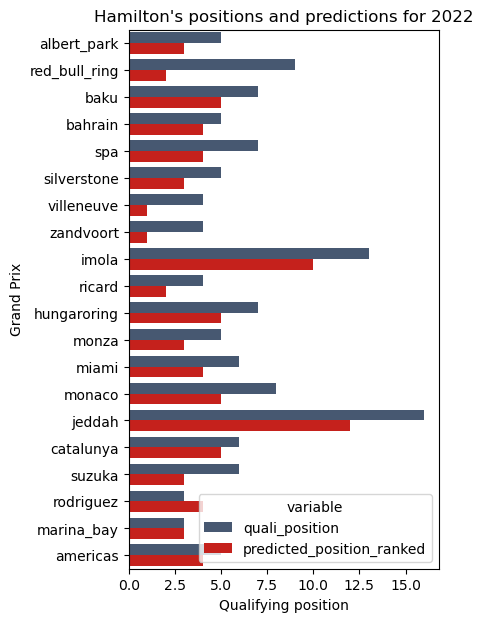

In [109]:
temp = hamilton_results[['driverRef','circuitRef','quali_position','predicted_position_ranked']]
temp2 = pd.melt(temp,id_vars=['driverRef','circuitRef'], value_vars=['quali_position','predicted_position_ranked'])
plt.figure(figsize=(4,7))
sns.barplot(temp2,x='value',y='circuitRef',hue='variable')
plt.xlabel('Qualifying position')
plt.ylabel('Grand Prix')
plt.title("Hamilton's positions and predictions for 2022")
plt.show()

Overal for Hamilton the model seemed to do ok. In the last 4 races, it predicted correctly for Singapore, Americas and was very close in Rodriquez. Overall it seemed to predict he would perform better than he did. This is understanable as Hamilton has had his first year of results in a long time, from dominating Formula 1 for the last 7 years, he has now had a car which can not competete at the front. Since the model was trained mostly on his good results, it is understandable that it predicted him to do better than expected.

How was the lap time delta predictions?

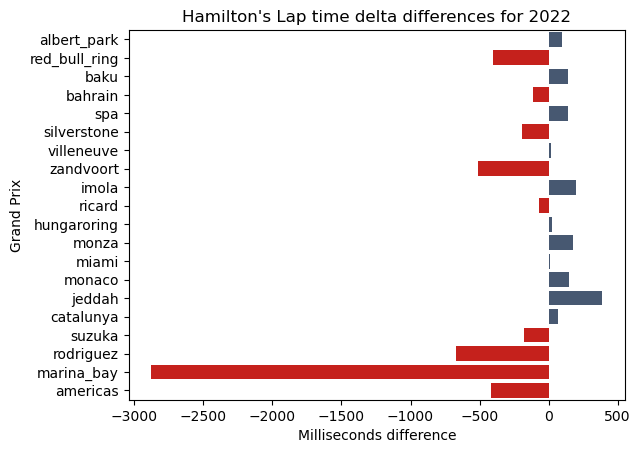

In [117]:
colors = ['#405678' if c >= 0 else '#E10600' for c in hamilton_results['laptime_delta_residual']]
sns.barplot(data=hamilton_results,x='laptime_delta_residual',y='circuitRef',palette=colors)
plt.title("Hamilton's Lap time delta differences for 2022")
plt.xlabel('Milliseconds difference')
plt.ylabel('Grand Prix')
plt.show()

For the majority of the races it predicted Hamilton's time delta to within half a second, which on face value is rather good considering the complexities of Formula1. For the last 4 races it over predicted his time delta, and for Singapore (Marina Bay circuit) it was almost 3 seconds off his true time delta. In addittion on the other test races Red Bull Ring and Zandvoort it also over predicted the results. Indicating the model maybe over training slightly.

The model maybe over predicting the lap time delta in the test cases because it does not learn the link between sector times and lap time delta or that it has not learnt the relationships between this years cars and the circuit.

# Project Summary 
<a id="projsummary"></a>

This project aimed to help race teams and fans of Formula1 by analysing and creating models which can predict the results of Qualifying. In this study a number of key insights have been found. Some of which are:

- Overall the models of position and lap time delta (time differnce to first place) where able to pick up on the overal trends and predict the results with a R2 square score of 0.5 to 0.6. 
- The best models were regression based as the mean absolute error was on average less than the bin size of the classification models
- The model learned a number of interesting features that helped the model predict the correct results, these included:
    - The variance & maximum RPM (revolution per minute) of the engine on the straight
    - The Maximum speed on the corners
    - The amount of distance a driver spent on the brakes in a given lap
    - Initial Sector 1 times 
    - Speed on the straights

Some of the features the model picked up on were expected, for example speed on the straight, speed in the corners and distance on the brakes because the fast drivers who brake less are likely to do better. However the other featuers such as RPM which was ranked highly for position and lap time delta prediction was un expected. This maybe picking up on the differences between the engines in the cars, cars which are more consistently hitting high RPMS are likely to do better than ones who performance is more erradict and don't reach the high numbers. Therefore, this analysis would recommend teams to investigate how to maximise the performance of the engine and reduce variance in RPM. Further investigation is required in these features and there impact.

The models have a number of limitations as well:

- Both the laptime delta and position prediction models show signs of over training with the test sets doing worse than the training datasets
- The dataset was small for machine learning with 1890 rows and high number of features the models will suffer with dimensionality and the lack of data
- The lap time delta model performed poorly on the "test" test set with mean absolute errors of 0.8 seconds
- As a regression technique was used the models especially for position did not predict the range of outcomes (1-20) and the data needed to be ranked afterwards to match
- Some of the features have outliers which can highly impact the predicted results. 
- The model struggled with unseen circuits, especially on lap time delta. This is likely because the features show more variability between circuits than driver performance

This limiations in the models are likely caused by the lack of data and that the variance in the features may be more related to the circuit that the driver performance. The lack of data is challenging, for example in 2022 the cars and rules were heavily changed so the cars are very different to 2021, this not only impacts which teams and drivers were performing well but likely has a large impact on the features for the model. This would make it extremely hard to accurately predict the results for circuits the model had not been trained on for 2022, as the features maybe very different to what was expected for that circuit.

In adittion, the fact that model struggles with certain GrandPrix's such as Sinapore in 2022 may indicate that a lot of the variance in the features may come from the circuit (Singapore is challenging street circuit) and not the drivers and teams performance.

Overall, this project has learned a number of interesting insights about Formula1 Qualifying, built models that have resonable level of accuracies (the position prediction performing better than lap time delta). In addittion it found out that Max Verstappen conviently has the largest number of missing telemetry days of the field, which may be considered suspect as one of the biggest protagonists. The models faces a number of limitations which made the predictions challenging, however they picked up on interesting features, for initial models they show promise. Further work may be able to reduce the impact of the limitations by generating and engineering more predictive features. In addittion as F1 live publishes more of this data, in the coming years the dataset will increase which will also help the models learn.

There are number of recommendations for future work on this project.

# Recomendations for Further Work
<a id="recommendations"></a>

As discussed the models have a number of limitations related to the predictive power of the features, lack of data and the fact that each year the rules are slightly different hence the cars have different characteristics. It is very difficult to tackle the challenges of limited data without waiting for more data to be collected over the next few years. However more work could be done on feature engineering.

Due to the limited time of the project a number of ideas couldnt be investigated.These include:

- Normalising the input features to the circuit characteristics, this could reduce issues seen especially in lap time delta, where anomalous features related to a particular long circuit or tight circuit impact the result.

- Generating features that look at the past Grand Prix's performance as an indicator of future results, since drivers results show a trend in any given season and using the average result of the last 5 GrandPrix's in that season may help the model predict the results in the next GrandPrix.

- Using automatic feature engineering techniques such as auto encoders, training machines to encode all the data in the lap telemetry into a single vector. The neural network may pick up and learn addittional features that were not thought of in the manual programming feature engineering approach taken in this project.

- Investigating classification models with bin size of 1 for position predictions to avoid the issues of averaging out position predictions. This project showed that classification with a large bin size miss classified because results were likely close to edges of the bins and the model predicted the wrong neighbour bin. However pure regression also struggled since the position result is ranked variable with always integers between 1-20. Therefore a classification with bin size of 1 may help.

- Build models to predict off practice 3 performance features. The challenge of these models is there use the data after the event to predict the result. Therefore limiting there use. The models could be more useful if they were forward predictive. That could be engineered by inputing the feature for certain driver, car circuit combinations based on previous races. Or by using practice 3 data, in practice 3 the last practice session before qualifying the teams often tune the car for a fast hot lap and therefore the data of those laps is usually indicative of who will perform well in qualifying

- Predict results at a lap level not at a race level. Due to the limited number of years of telemetry data, more data can be created if the model predicts the lap times at a lap level and not a race level and therefore the final aggregations from lap to race level are not needed and the dataset would be dramatically bigger.

It is recommended to focus on next on improving the feature engineering through manual and automatic techniques, if those show improved results, look to translate the models to predicting based on practice 3 data. If the approaches on feature engineering fail to improve the models, it is recommended to look at predicting lap performance based on individual lap data. This would teach teams what are the most predictive features at a lap level and can help provide insights on where they should focus to improve performance at different circuits. 